In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib as mpl
import matplotlib.patches as ptc
mpl.rcParams['figure.dpi'] = 500

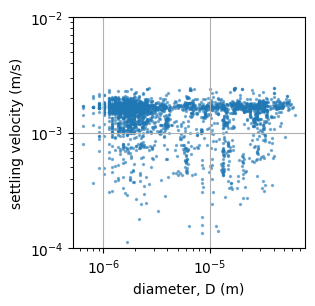

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def read_particle_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            area, width, height, ratio, cX, cY = map(float, line.strip().split('\t'))
            data.append({'area': area, 'width': width, 'height': height, 'ratio': ratio, 'cX': cX, 'cY': cY})
    return data

def find_local_matches(particles_frame1, particles_frame2, search_radius, size_weight=0.5, dimension_weight=0.3):
    """
    Find matches between particles in two consecutive frames based on spatial distance, size, and dimension similarity.
    
    :param particles_frame1: List of particle dictionaries in frame 1
    :param particles_frame2: List of particle dictionaries in frame 2
    :param search_radius: Maximum allowed distance for matching particles
    :param size_weight: Weight of the size difference in the score (0 to 1)
    :param dimension_weight: Weight of the height and width differences in the score (0 to 1)
    :return: List of matches (particle1, particle2, distance)
    """
    matches = []
    for particle1 in particles_frame1:
        local_matches = []
        for particle2 in particles_frame2:
            distance = np.sqrt((particle1['cX'] - particle2['cX'])**2 + (particle1['cY'] - particle2['cY'])**2)
            if distance <= search_radius:
                height_diff = abs(particle1['height'] - particle2['height'])
                width_diff = abs(particle1['width'] - particle2['width'])
                
                avg_height = (particle1['height'] + particle2['height']) / 2
                avg_width = (particle1['width'] + particle2['width']) / 2
                normalized_height_diff = height_diff / avg_height if avg_height != 0 else 0
                normalized_width_diff = width_diff / avg_width if avg_width != 0 else 0
                
                score = (1 - size_weight - dimension_weight) * distance + \
                        size_weight * normalized_height_diff + \
                        dimension_weight * normalized_width_diff
                
                local_matches.append((particle2, score))
        
        local_matches.sort(key=lambda x: x[1])
        
        if local_matches:
            matches.append((particle1, local_matches[0][0], local_matches[0][1]))
    
    return matches

def calculate_distance_and_average_area(matches):
    distances = []
    average_areas = []
    for particle1, particle2, distance in matches:
        avg_area = (particle1['area'] + particle2['area']) / 2
        distances.append(distance)
        average_areas.append(avg_area)
    return distances, average_areas

def calculate_diameter_from_area(area_in_meters_squared):
    return 2 * np.sqrt(area_in_meters_squared / np.pi)

def process_frame_pairs(directory, start_frame, end_frame):
    all_distances = []
    all_diameters = []

    for frame_number in range(start_frame, end_frame):
        file1 = os.path.join(directory, f'frame_{frame_number:03}_measurements.txt')
        file2 = os.path.join(directory, f'frame_{frame_number+1:03}_measurements.txt')
        
        particles_frame1 = read_particle_data(file1)
        particles_frame2 = read_particle_data(file2)
        
        search_radius = 500
        matches = find_local_matches(particles_frame1, particles_frame2, search_radius)
        
        distances, average_areas = calculate_distance_and_average_area(matches)
        for area in average_areas:
            area_in_micron_squared = area * (0.81 ** 2)  # Convert area from pixel^2 to micron^2
            area_in_meters_squared = area_in_micron_squared * (1e-6 ** 2)  # Convert area from micron^2 to meter^2
            diameter_in_meters = calculate_diameter_from_area(area_in_meters_squared)
            all_diameters.append(diameter_in_meters)
        
        all_distances.extend([distance * 0.81 * 1e-6 for distance in distances])  # Convert distances directly to meters

    return all_distances, all_diameters

# Directory and frame range setup
directory = '/Users/braydennoh/Downloads/Last100Frames/test'
start_frame = 1
end_frame = 75

all_distances, all_diameters = process_frame_pairs(directory, start_frame, end_frame)
distances_per_second = [distance * 30 for distance in all_distances]

plt.figure(figsize=(3, 3))

plt.scatter(all_diameters, distances_per_second, s=2, alpha=0.5)
plt.xlabel('diameter, D (m)')
plt.ylabel('settling velocity (m/s)')
plt.ylim([1e-4,1e-2])
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

In [2]:
def update_global_particles(particles_frame, frame_number, global_particles, next_particle_id, search_radius=500, size_weight=0.5, dimension_weight=0.3):
    """
    Update global_particles with particles from the current frame.
    
    :param particles_frame: List of particle dictionaries in the current frame
    :param frame_number: Current frame number (for tracking)
    :param global_particles: Dictionary of all tracked particles
    :param next_particle_id: Next available unique ID for new particles
    :param search_radius: Maximum allowed distance for matching particles
    :param size_weight: Weight of the size difference in the score
    :param dimension_weight: Weight of the dimension difference in the score
    :return: Updated global_particles and next_particle_id
    """
    for particle in particles_frame:
        best_match = None
        best_score = float('inf')
        for pid, data in global_particles.items():
            # Assume data has 'frame_number' to track last seen frame and 'cX', 'cY' for position
            if data['frame_number'] == frame_number - 1:  # Only match with particles from the previous frame
                distance = np.sqrt((data['cX'] - particle['cX'])**2 + (data['cY'] - particle['cY'])**2)
                if distance <= search_radius:
                    height_diff = abs(data['height'] - particle['height'])
                    width_diff = abs(data['width'] - particle['width'])
                    
                    avg_height = (data['height'] + particle['height']) / 2
                    avg_width = (data['width'] + particle['width']) / 2
                    normalized_height_diff = height_diff / avg_height if avg_height != 0 else 0
                    normalized_width_diff = width_diff / avg_width if avg_width != 0 else 0
                    
                    score = (1 - size_weight - dimension_weight) * distance + \
                            size_weight * normalized_height_diff + \
                            dimension_weight * normalized_width_diff
                    
                    if score < best_score:
                        best_match = pid
                        best_score = score
        
        if best_match is not None:
            # Update existing particle with new data
            global_particles[best_match].update(particle)
            global_particles[best_match]['frame_number'] = frame_number
        else:
            # Add new particle with next available ID
            global_particles[next_particle_id] = particle
            global_particles[next_particle_id]['frame_number'] = frame_number
            next_particle_id += 1
    
    return global_particles, next_particle_id

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

def read_particle_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            area, width, height, ratio, cX, cY = map(float, line.strip().split('\t'))
            data.append({'area': area, 'width': width, 'height': height, 'ratio': ratio, 'cX': cX, 'cY': cY})
    return data

def update_global_particles(particles_frame, frame_number, global_particles, next_particle_id, search_radius=500, size_weight=0.5, dimension_weight=0.3):
    """
    Update global_particles with particles from the current frame.
    
    :param particles_frame: List of particle dictionaries in the current frame
    :param frame_number: Current frame number (for tracking)
    :param global_particles: Dictionary of all tracked particles
    :param next_particle_id: Next available unique ID for new particles
    :param search_radius: Maximum allowed distance for matching particles
    :param size_weight: Weight of the size difference in the score
    :param dimension_weight: Weight of the dimension difference in the score
    :return: Updated global_particles and next_particle_id
    """
    for particle in particles_frame:
        best_match = None
        best_score = float('inf')
        for pid, data in global_particles.items():
            # Assume data has 'frame_number' to track last seen frame and 'cX', 'cY' for position
            if data['frame_number'] == frame_number - 1:  # Only match with particles from the previous frame
                distance = np.sqrt((data['cX'] - particle['cX'])**2 + (data['cY'] - particle['cY'])**2)
                if distance <= search_radius:
                    height_diff = abs(data['height'] - particle['height'])
                    width_diff = abs(data['width'] - particle['width'])
                    
                    avg_height = (data['height'] + particle['height']) / 2
                    avg_width = (data['width'] + particle['width']) / 2
                    normalized_height_diff = height_diff / avg_height if avg_height != 0 else 0
                    normalized_width_diff = width_diff / avg_width if avg_width != 0 else 0
                    
                    score = (1 - size_weight - dimension_weight) * distance + \
                            size_weight * normalized_height_diff + \
                            dimension_weight * normalized_width_diff
                    
                    if score < best_score:
                        best_match = pid
                        best_score = score
        
        if best_match is not None:
            # Update existing particle with new data
            global_particles[best_match].update(particle)
            global_particles[best_match]['frame_number'] = frame_number
        else:
            # Add new particle with next available ID
            global_particles[next_particle_id] = particle
            global_particles[next_particle_id]['frame_number'] = frame_number
            next_particle_id += 1
    
    return global_particles, next_particle_id

def process_all_frames(directory, start_frame, end_frame):
    global_particles = {}
    next_particle_id = 0
    for frame_number in range(start_frame, end_frame + 1):
        file_path = os.path.join(directory, f'frame_{frame_number:03}_measurements.txt')
        particles_frame = read_particle_data(file_path)
        global_particles, next_particle_id = update_global_particles(particles_frame, frame_number, global_particles, next_particle_id)
    
    # At this point, global_particles contains tracked particles across frames

# Include any necessary adaptations of calculate_distance_and_average_area or other functions

import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming all previous functions and global setup are correctly defined

def analyze_and_plot(global_particles, pixels_per_meter=1.23e6, frame_rate=30):
    """
    Analyze particle distribution and plot diameter vs. distance traveled.
    
    :param global_particles: Dictionary of tracked particles
    :param pixels_per_meter: Conversion factor from pixels to meters
    :param frame_rate: Frame rate of the video to calculate time
    """
    diameters = []  # List to store diameters of particles
    distances_meters = []  # List to store distances traveled in meters
    velocities_m_per_s = []  # List to store velocities in meters per second

    for pid, data in global_particles.items():
        # Calculate diameter
        area_in_meters_squared = data['area'] / pixels_per_meter**2
        diameter = calculate_diameter_from_area(area_in_meters_squared)
        diameters.append(diameter)
        
        # Assume 'distance_traveled' in pixels is stored for each particle
        distance_meters = data.get('distance_traveled', 0) / pixels_per_meter
        distances_meters.append(distance_meters)
        
        # Calculate velocity (meters per second)
        # Assuming 'time_traveled' in frames is stored for each particle
        time_seconds = data.get('time_traveled', 1) / frame_rate
        velocity_m_per_s = distance_meters / time_seconds
        velocities_m_per_s.append(velocity_m_per_s)
    
    # Plot Diameter Distribution
    plt.figure(figsize=(10, 5))
    plt.hist(diameters, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Diameter (m)')
    plt.ylabel('Frequency')
    plt.title('Particle Diameter Distribution')
    plt.grid(True)
    plt.show()

    # Plot Diameter vs. Velocity
    plt.figure(figsize=(10, 5))
    plt.scatter(diameters, velocities_m_per_s, alpha=0.5)
    plt.xlabel('Diameter (m)')
    plt.ylabel('Settling Velocity (m/s)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.title('Diameter vs. Settling Velocity')
    plt.show()

# Example call to analyze_and_plot
analyze_and_plot(global_particles)


# Example usage:
directory = '/Users/braydennoh/Downloads/Last100Frames/test'
start_frame = 1
end_frame = 75
process_all_frames(directory, start_frame, end_frame)

# Further analysis goes here, e.g., analyzing particle distribution



In [5]:
global_particles

NameError: name 'global_particles' is not defined

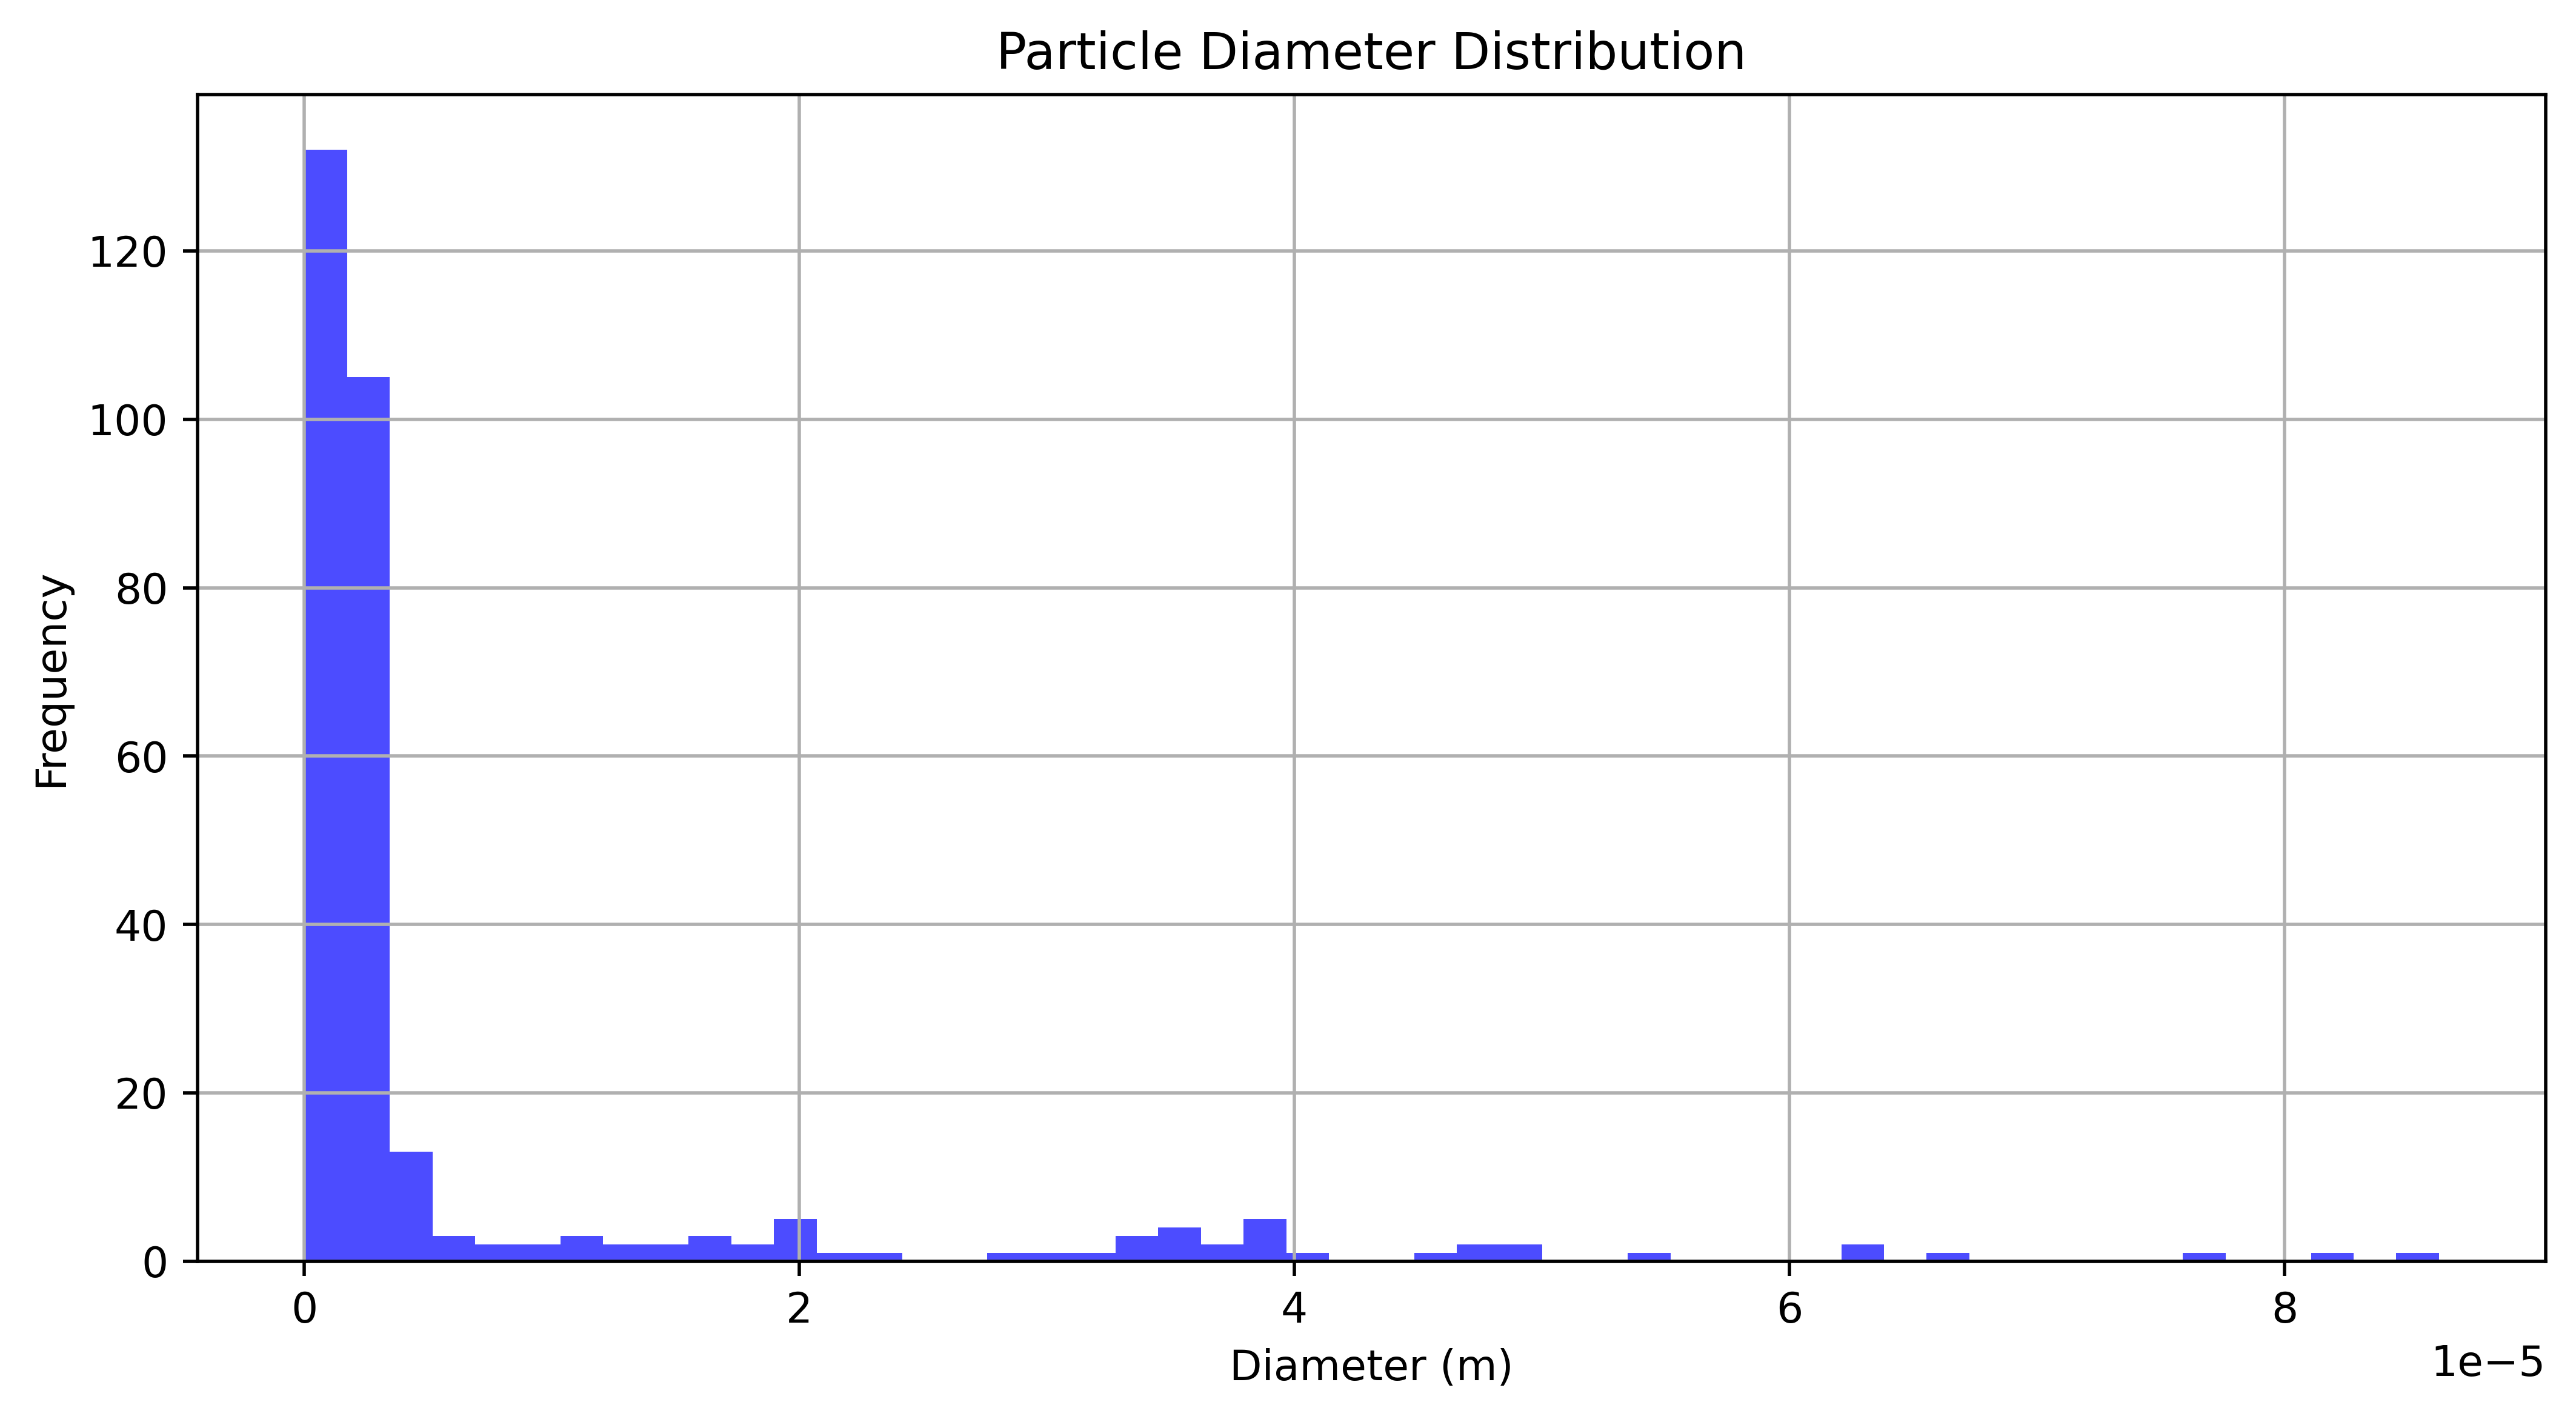

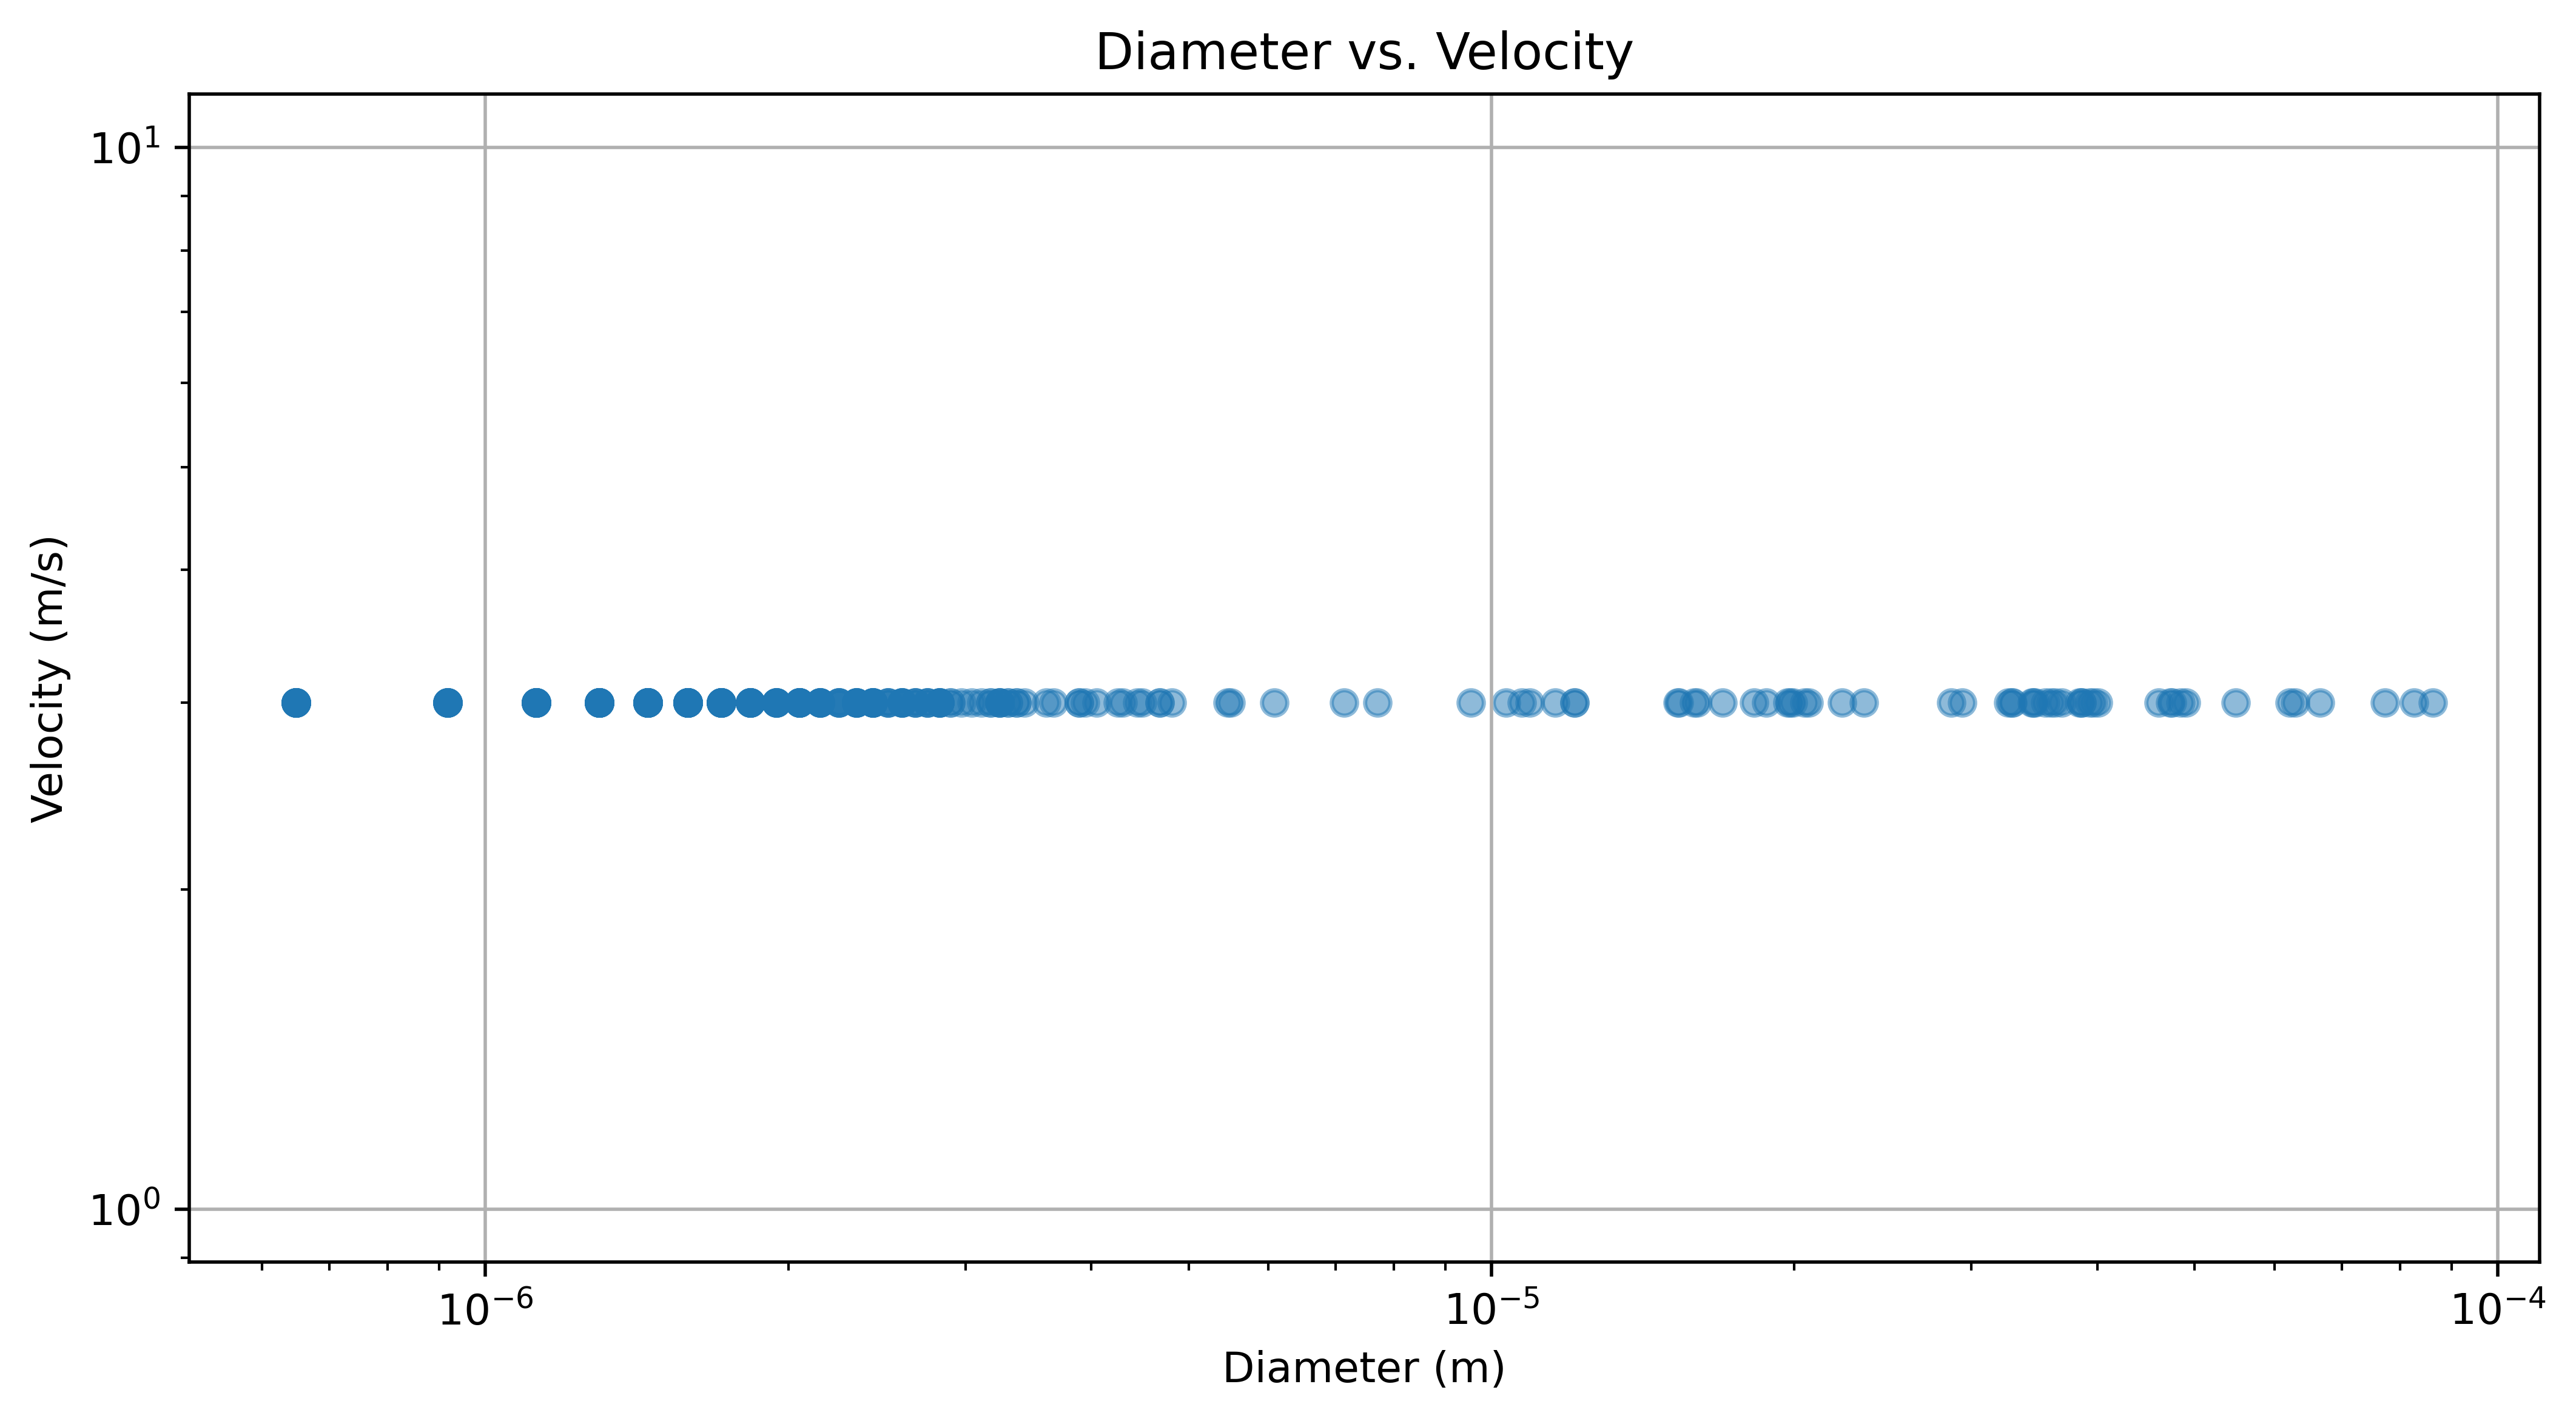

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

def read_particle_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            area, width, height, ratio, cX, cY = map(float, line.strip().split('\t'))
            data.append({'area': area, 'width': width, 'height': height, 'ratio': ratio, 'cX': cX, 'cY': cY})
    return data

def calculate_diameter_from_area(area_in_meters_squared):
    return 2 * np.sqrt(area_in_meters_squared / np.pi)

def update_global_particles(particles_frame, frame_number, global_particles, next_particle_id, search_radius=500, size_weight=0.5, dimension_weight=0.3):
    for particle in particles_frame:
        best_match = None
        best_score = float('inf')
        for pid, data in global_particles.items():
            if 'frame_number' in data and data['frame_number'] < frame_number:  # Check only for previous frames
                distance = np.sqrt((data['cX'] - particle['cX'])**2 + (data['cY'] - particle['cY'])**2)
                if distance <= search_radius:
                    height_diff = abs(data['height'] - particle['height'])
                    width_diff = abs(data['width'] - particle['width'])
                    
                    avg_height = (data['height'] + particle['height']) / 2
                    avg_width = (data['width'] + particle['width']) / 2
                    normalized_height_diff = height_diff / avg_height if avg_height != 0 else 0
                    normalized_width_diff = width_diff / avg_width if avg_width != 0 else 0
                    
                    score = (1 - size_weight - dimension_weight) * distance + \
                            size_weight * normalized_height_diff + \
                            dimension_weight * normalized_width_diff
                    
                    if score < best_score:
                        best_match = pid
                        best_score = score
        
        if best_match is not None:
            # Update existing particle data and track its movement
            global_particles[best_match]['frame_number'] = frame_number  # Update last seen frame
            # Optionally track distance traveled and other metrics here
        else:
            # Add new particle
            global_particles[next_particle_id] = particle
            global_particles[next_particle_id]['frame_number'] = frame_number
            next_particle_id += 1
    
    return global_particles, next_particle_id

def process_all_frames(directory, start_frame, end_frame):
    global_particles = {}
    next_particle_id = 0
    for frame_number in range(start_frame, end_frame + 1):
        file_path = os.path.join(directory, f'frame_{frame_number:03}_measurements.txt')
        particles_frame = read_particle_data(file_path)
        global_particles, next_particle_id = update_global_particles(particles_frame, frame_number, global_particles, next_particle_id)
    return global_particles

def analyze_and_plot(global_particles, pixels_per_meter=1.23e6, frame_rate=30):
    diameters = []  # Diameters of particles
    velocities_m_per_s = []  # Velocities in meters per second

    # Placeholder for distance and time calculations
    # This part requires tracking distance traveled and time spent across frames for each particle
    
    # For demonstration, assuming each particle appears once and moves a fixed distance (for simplicity)
    for pid, data in global_particles.items():
        area_in_meters_squared = data['area'] / pixels_per_meter**2
        diameter = calculate_diameter_from_area(area_in_meters_squared)
        diameters.append(diameter)
        # Placeholder for real distance and time calculations
        distance_meters = 0.1  # Example fixed distance
        time_seconds = 1 / frame_rate  # Example time spent
        velocity_m_per_s = distance_meters / time_seconds
        velocities_m_per_s.append(velocity_m_per_s)
    
    plt.figure(figsize=(10, 5))
    plt.hist(diameters, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Diameter (m)')
    plt.ylabel('Frequency')
    plt.title('Particle Diameter Distribution')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(diameters, velocities_m_per_s, alpha=0.5)
    plt.xlabel('Diameter (m)')
    plt.ylabel('Velocity (m/s)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.title('Diameter vs. Velocity')
    plt.show()

# Adjust the directory, start_frame, and end_frame to your actual data path and frame range
directory = '/Users/braydennoh/Downloads/Last100Frames/test'
start_frame = 1
end_frame = 75

global_particles = process_all_frames(directory, start_frame, end_frame)
analyze_and_plot(global_particles)